# MLP on MINST Dataset

In [1]:
Pkg.update()
Pkg.add("MNIST")
using PyPlot

INFO: Updating METADATA...
INFO: Computing changes...
INFO: No packages to install, update or remove
INFO: Nothing to be done
/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Data Generation & Datasplit

In [3]:
using MNIST

function mnistData()
    features = trainfeatures(1)
    label = trainlabel(1)
    

    trainX, trainY = traindata()
    N = size(trainX)[2]
    idx = randperm(N)
    trainX = trainX[:, idx]'
    trainY = trainY[idx]

    testX, testY = testdata()
    N = size(testX)[1]
    idx = randperm(N)
    testX = testX[:, idx]'
    testY = testY[idx]

    ttl = 1000
    trX, trY = trainX[1:ttl,:], trainY[1:ttl,:]

    @assert size(trX)[1] == size(trY)[1]
    println(size(trX), size(trY))

    trX = trX / 256. 
    return trX, trY
end

function datasplit(trX, trY)
    local N = size(trY)[1]
    local size_training = convert(Int, N * 8/10)
    local size_testing = convert(Int, N / 10)
    local train_set = (trX[1:size_training,:],trY[1:size_training,:])
    local test_set = (trX[size_training + 1:size_training + size_testing, :], 
                                trY[size_training + 1 : size_training + size_testing, :])
    local validation_set =  (trX[size_training + size_testing + 1:N, :], 
                                    trY[size_training + size_testing + 1:N,:])
    return train_set, test_set, validation_set
end

#data generation:
X, Y = mnistData()

#data split:
train_set, test_set, validation_set = datasplit(X, Y)
trX, trY = train_set[1], train_set[2]
valX, valY = validation_set[1], validation_set[2]
teX, teY = test_set[1], test_set[2]



(1000,784)(1000,1)


(
[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],

[8.0; 4.0; … ; 9.0; 5.0])

In [4]:
include("layers/SoftMaxCrossEntropy.jl")
include("layers/SquareLossLayer.jl")
include("layers/FCLayer.jl")
include("layers/DropoutLayer.jl")
include("layers/ReLu.jl")
include("layers/Tanh.jl")
include("layers/SequnetialNet.jl")

([2.40761,1.31818],[2,1])
[0.244728 -0.909969 0.665241; 0.00490169 0.727475 -0.732377]
Diff: [0.0; 0.0; 2.0; 5.0]
(
[14.5],

[-1; 1; 1; 1])
dldy:[0.0; 0.0; 2.0; 5.0]
[0.0; 0.0; 2.0; 5.0]
FCLayer(2,[-5.94174 1.28643 -4.59907; 1.92438 -2.19656 -1.65294; 0.0 0.0 0.0],[0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0])
[3.0 22.0 21.0; 7.0 46.0 45.0]
[56.0 110.0; 74.0 144.0]
[26.0 30.0 34.0; 38.0 44.0 50.0; 12.0 14.0 16.0]
[1.0 2.0; 0.0 3.0; 1.0 0.0; 0.0 0.0]
[2.0 3.0; 0.0 5.0; 3.0 0.0; 0.0 0.0]
[0.761594 0.964028; -0.761594 0.995055; 0.761594 -0.964028; -0.995055 -0.995055]
[0.839949 0.211952; 0.839949 0.0493302; 1.25992 0.423905; 0.0197321 0.0197321]


backward (generic function with 7 methods)

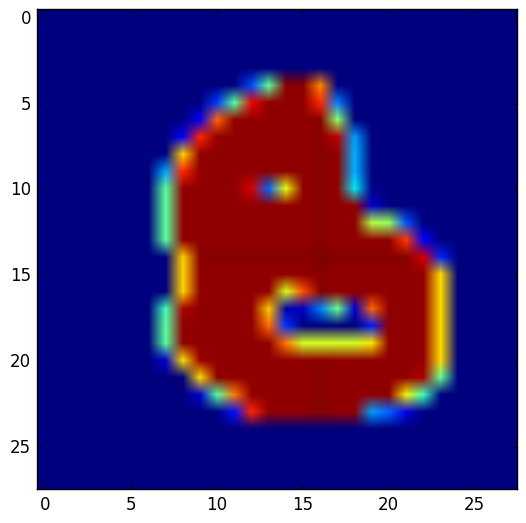

(800,784)(800,1)


PyObject <matplotlib.image.AxesImage object at 0x36b369250>

In [10]:
println(size(trX), size(trY))
i = convert(Int, ceil(rand() * size(trY)[1]))
x =reshape(trX[i,:], 28,28) ./ 256
imshow(x)

# Network Structure

In [20]:
function build_mlp()
    layers = [
        DropoutLayer(0.2),
        FCLayer(784, 800),
        ReLu(),
        DropoutLayer(0.5),
        FCLayer(800, 800),
        ReLu(),
        DropoutLayer(0.5),
        FCLayer(800, 10)
    ]
    criteria = SoftMaxCrossEntropyLoss()
    net = SequentialNet(layers, criteria)
    return net
end

build_mlp (generic function with 1 method)

In [21]:
function get_corr(pred, answ)
    return length(filter(e -> abs(e) < 1e-5, pred-answ))
end

function train(net::SequentialNet, train_set, validation_set; batch_size::Int64 = 64, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), alpha::Float64 = 0.9, verbose=0)
    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []
    
    local val_losses = []
    local val_accu   = []
    for epo = 1:ttl_epo
        local num_batch = ceil(N/batch_size)
        if verbose > 0
            println("Epo $(epo) num batches : $(num_batch)")
        end
        all_losses = []
        epo_cor = 0
        for bid = 0:(num_batch-1)
            batch += 1
            local sidx::Int = convert(Int64, bid*batch_size+1)
            local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
            local batch_X = X[sidx:eidx,:]
            local batch_Y = Y[sidx:eidx,:]
            loss, _ = forward(net, batch_X, batch_Y)
            backward(net, batch_Y)
            append!(all_losses, mean(loss))
            for i = 1:length(net.layers)
                local layer = net.layers[i]
                local gradi = lrSchedule(epo) * gradient(layer) / batch_size
                local veloc = getLDiff(layer) * alpha - gradi
                local theta = getParam(layer) + alpha * veloc - gradi
                if verbose > 2
                    print("Layer $(i)")
                    print("\tGradient: $(sum(abs(theta - getLDiff(layer))))")
                    if verbose > 1
                        print("\tLastloss: $(sum(abs(layer.last_loss)))")
                    end
                    println()
                end
                setParam!(layer, theta)
            end

            _, pred = forward(net, batch_X, batch_Y; deterministics = true)
            epo_cor  += length(filter(e ->  abs(e) < 1e-5, pred - batch_Y))
            local acc = length(filter(e -> abs(e) < 1e-5, pred - batch_Y)) / batch_size

            if verbose > 1
                println("[$(bid)/$(num_batch)]Loss is: $(loss)\tAccuracy:$(acc)")
            end
        end
        local epo_loss = mean(all_losses)
        local epo_accu = epo_cor / N
        append!(epo_losses, epo_loss)
        append!(epo_accus, epo_accu)
        
        # Run validation set
        v_ls, v_pd = forward(net, valX, valY)
        local v_loss = mean(v_ls)
        v_size = size(valX)[1]
        v_accu = get_corr(v_pd, valY) / v_size
        append!(val_losses, v_loss)
        append!(val_accu,   v_accu)
        
        if verbose > 0
            println("Epo $(epo) has loss :$(epo_loss)\t\taccuracy : $(epo_accu)")
        end
    end
    return epo_losses,epo_accus, val_losses, val_accu
end

train (generic function with 1 method)

In [17]:
println(size(trX),size(trY),size(valX),size(valY),size(teX),size(teY))

(800,784)(800,1)(100,784)(100,1)(100,784)(100,1)


Prediction :0 Index:205
Prediction :0 Correct Value :6.0 Index:11


Prediction :0 Correct Value :9.0 Index:363
Prediction :0 Correct Value :4.0 Index:602
Prediction :0 Correct Value :5.0 Index:48
Prediction :7 Correct Value :9.0 Index:73
Prediction :0 Correct Value :6.0 Index:657
Prediction :0 Correct Value :2.0 Index:175
Prediction :0 Correct Value :4.0 Index:751
Prediction :0 Correct Value :4.0 Index:216


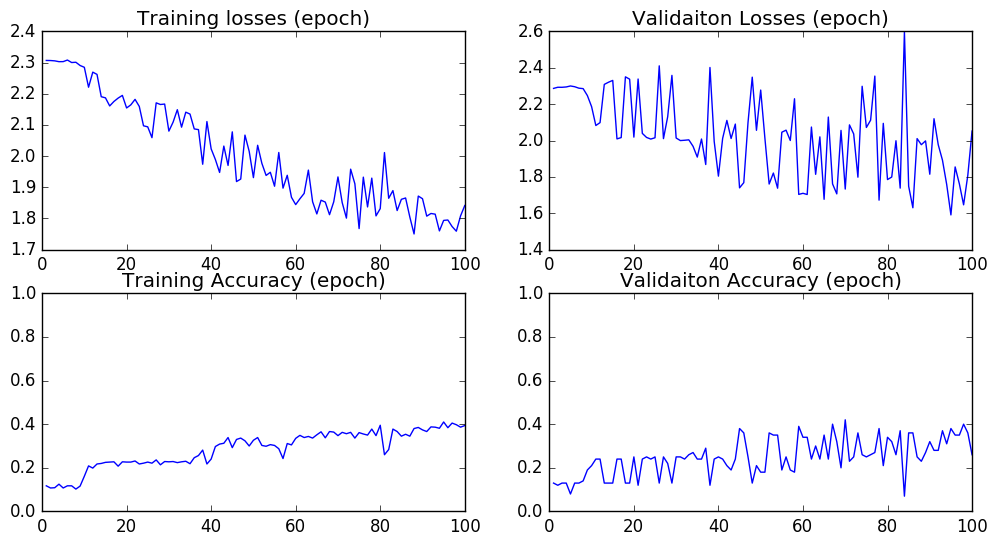

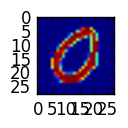

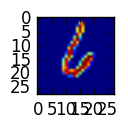

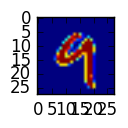

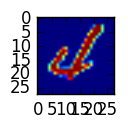

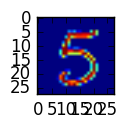

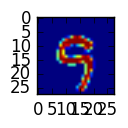

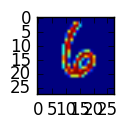

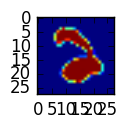

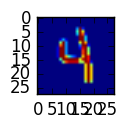

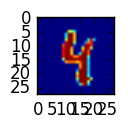

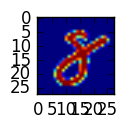

Prediction :0 Correct Value :8.0 Index:76


In [27]:
function demoTrain(trX, trY, valX, valY, teX, teY;total_epo=100)
    net = build_mlp()
    epo_losses, epo_accu, val_losses, val_accu = train(net, (trX, trY), (valX, valY), ttl_epo = total_epo; batch_size = 50,
               lrSchedule = x -> 0.05, verbose=0, alpha=0.9)
    
    figure(figsize=(12,6))
    subplot(221)
    plot(1:length(epo_losses), epo_losses)
    title("Training losses (epoch)")

    subplot(223)
    plot(1:length(epo_accu), epo_accu)
    ylim([0, 1])
    title("Training Accuracy (epoch)")

    subplot(222)
    plot(1:length(val_losses), val_losses)
    title("Validaiton Losses (epoch)")

    subplot(224)
    plot(1:length(val_accu), val_accu)
    ylim([0, 1])
    title("Validaiton Accuracy (epoch)")

    train_loss, pred = forward(net, trX, trY; deterministics = true)
    N = size(trX)[1]
    right_idx = filter(i-> abs(pred[i] - trY[i]) <  1e-5, 1:N)
    wrong_idx = filter(i-> abs(pred[i] - trY[i]) >= 1e-5, 1:N)
    
    # print out the data for the correct images
    rand_idx = right_idx[convert(Int, ceil(rand() * length(right_idx)))]
    x =reshape(trX[rand_idx,:], 28,28)
    figure(figsize=(1,1))
    imshow(x)
    println("Prediction :$(pred[rand_idx]) Index:$(rand_idx)")
    
    # print out some incorrect images
    for i in 1:10
    rand_idx = wrong_idx[convert(Int, ceil(rand() * length(wrong_idx)))]
    x =reshape(trX[rand_idx,:], 28,28)
    figure(figsize=(1,1))
    imshow(x)
    println("Prediction :$(pred[rand_idx]) Correct Value :$(trY[rand_idx]) Index:$(rand_idx)")
    end
    
end

demoTrain(trX, trY, valX, valY, teX, teY;total_epo = 100)


# subplot(121)
# plot(1:length(losses), losses)
# title("Epoch Losses")

# subplot(122)
# plot(1:length(accus), accus)
# title("Epoch Accuracy")
# show()


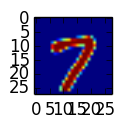

Prediction :7 Index:2473


In [69]:
# print out the data for the correct images
rand_idx = right_idx[convert(Int, ceil(rand() * length(right_idx)))]
x =reshape(trainX[rand_idx,:], 28,28)
figure(figsize=(1,1))
imshow(x)
println("Prediction :$(pred[rand_idx]) Index:$(rand_idx)")


In [95]:
# print out some incorrect images
for i in 1:10
rand_idx = wrong_idx[convert(Int, ceil(rand() * length(wrong_idx)))]
x =reshape(trainX[rand_idx,:], 28,28)
figure(figsize=(1,1))
#imshow(x)
    println("Prediction :$(pred[rand_idx]) Correct Value :$(trainY[rand_idx]) Index:$(rand_idx)")
end

Prediction :1 Correct Value :9.0 Index:1244
Prediction :2 Correct Value :0.0 Index:3200
Prediction :1 Correct Value :8.0 Index:1939
Prediction :1 Correct Value :5.0 Index:234
Prediction :2 Correct Value :0.0 Index:3540
Prediction :1 Correct Value :5.0 Index:4637
Prediction :2 Correct Value :0.0 Index:239
Prediction :1 Correct Value :9.0 Index:2958
Prediction :1 Correct Value :8.0 Index:3341
Prediction :10 Correct Value :2.0 Index:4827


In [96]:
N = size(trainX)[1]
super_wrong = filter(i -> abs(pred[i] -10)<1e-5, 1:N)
length(super_wrong)

79